# Model Training & Selection for Predictive Maintenance
## Machine Learning Model Development and Evaluation

## 1. Setup and Data Preparation

In [35]:
# Import necessary libraries for modeling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

print("All libraries imported successfully!")

All libraries imported successfully!


In [36]:
df = pd.read_csv("predictive_maintenance.csv")
df = df.drop(columns = ['UDI','Product ID','Failure Type'])
df = pd.get_dummies(df, columns=['Type'], drop_first=False)

X = df.drop(columns = 'Target')
y= df['Target']
feature_columns = X.columns
print("Data Preparation Status:")
print(f"Feature Matrix Shape: {X.shape}")
print(f"Target Vector Shape: {y.shape}")
print(f"Class Distribution:\n{pd.Series(y).value_counts()}")
feature_columns 

Data Preparation Status:
Feature Matrix Shape: (10000, 8)
Target Vector Shape: (10000,)
Class Distribution:
Target
0    9661
1     339
Name: count, dtype: int64


Index(['Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Type_H',
       'Type_L', 'Type_M'],
      dtype='object')

## 2. Train-Test Split with Stratification

In [37]:
# Split the data with stratification to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print("Data Split Summary:")
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"\nTraining set target distribution:")
print(pd.Series(y_train).value_counts())
print(f"\nTest set target distribution:")
print(pd.Series(y_test).value_counts())

Data Split Summary:
Training set size: 8000 samples
Test set size: 2000 samples

Training set target distribution:
Target
0    7729
1     271
Name: count, dtype: int64

Test set target distribution:
Target
0    1932
1      68
Name: count, dtype: int64


## 3. Model Pipeline Creation

In [38]:
# Create preprocessing pipeline
def create_pipeline(model, scale_features=True):
    """Create a pipeline with optional scaling and model"""
    if scale_features:
        return Pipeline([
            ('scaler', StandardScaler()),
            ('model', model)
        ])
    else:
        return Pipeline([
            ('model', model)
        ])

print(" Pipeline creation function ready!")

 Pipeline creation function ready!


## 4. Model Initialization

In [39]:
# Initialize comprehensive set of models to evaluate
models = {
    # Linear Models
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    
    # Tree-based Models
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'Extra Trees': ExtraTreesClassifier(random_state=42, n_estimators=100),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss'),
    
    # Instance-based Models
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    
    # Probabilistic Models
    'Naive Bayes': GaussianNB(),
    
    # Support Vector Machines
    'Support Vector Machine': SVC(random_state=42, probability=True),
    
    # Neural Networks
    'Neural Network': MLPClassifier(random_state=42, max_iter=1000)
}

# Create pipelines for each model
pipelines = {}
for name, model in models.items():
    # Tree-based models don't always need scaling
    if 'Tree' in name or name in ['Random Forest', 'Extra Trees', 'Gradient Boosting', 'AdaBoost', 'XGBoost']:
        pipelines[name] = create_pipeline(model, scale_features=False)
    else:
        pipelines[name] = create_pipeline(model, scale_features=True)

print(f"Initialized {len(models)} models for evaluation:")
for i, name in enumerate(models.keys(), 1):
    print(f"  {i:2d}. {name}")

Initialized 11 models for evaluation:
   1. Logistic Regression
   2. Random Forest
   3. Extra Trees
   4. Decision Tree
   5. Gradient Boosting
   6. AdaBoost
   7. XGBoost
   8. K-Nearest Neighbors
   9. Naive Bayes
  10. Support Vector Machine
  11. Neural Network


## 5. Cross-Validation Evaluation

In [40]:
# Perform comprehensive cross-validation for model selection
cv_results = {}
cv_scores = {}
cv_std = {}

# Use StratifiedKFold for better cross-validation with imbalanced data
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("🔍 Cross-Validation Results (5-fold Stratified):")
print("=" * 70)
print(f"{'Model':<25} | {'Mean Accuracy':<12} | {'Std Dev':<8} | {'Min Score':<9} | {'Max Score':<9}")
print("=" * 70)

for name, pipeline in pipelines.items():
    try:
        # Perform cross-validation
        scores = cross_val_score(pipeline, X_train, y_train, cv=skf, scoring='accuracy')
        
        cv_results[name] = scores
        cv_scores[name] = scores.mean()
        cv_std[name] = scores.std()
        
        print(f"{name:<25} | {scores.mean():.4f}       | {scores.std():.4f}   | {scores.min():.4f}    | {scores.max():.4f}")
        
    except Exception as e:
        print(f"{name:<25} | ERROR: {str(e)[:30]}")
        cv_scores[name] = 0  # Set to 0 for models that fail

print("=" * 70)

# Identify best models
sorted_models = sorted(cv_scores.items(), key=lambda x: x[1], reverse=True)
print(f"\nTop 5 Models by Cross-Validation Accuracy:")
for i, (name, score) in enumerate(sorted_models[:5], 1):
    if score > 0:
        print(f"  {i}. {name}: {score:.4f} ± {cv_std.get(name, 0):.4f}")

🔍 Cross-Validation Results (5-fold Stratified):
Model                     | Mean Accuracy | Std Dev  | Min Score | Max Score
Logistic Regression       | 0.9703       | 0.0013   | 0.9681    | 0.9719
Random Forest             | 0.9790       | 0.0020   | 0.9762    | 0.9819
Extra Trees               | 0.9764       | 0.0018   | 0.9738    | 0.9794
Decision Tree             | 0.9794       | 0.0034   | 0.9756    | 0.9850
Gradient Boosting         | 0.9835       | 0.0017   | 0.9806    | 0.9856
AdaBoost                  | 0.9742       | 0.0011   | 0.9725    | 0.9756
XGBoost                   | ERROR: 
All the 5 fits failed.
It is 
K-Nearest Neighbors       | 0.9744       | 0.0014   | 0.9719    | 0.9756
Naive Bayes               | 0.9600       | 0.0016   | 0.9587    | 0.9631
Support Vector Machine    | 0.9725       | 0.0024   | 0.9688    | 0.9756
Neural Network            | 0.9793       | 0.0032   | 0.9756    | 0.9831

Top 5 Models by Cross-Validation Accuracy:
  1. Gradient Boosting: 0.9835 ± 0.

## 6. Hyperparameter Tuning for Top Models

In [ ]:
# Define parameter grids for top performing models
param_grids = {
    'Random Forest': {
        'model__n_estimators': [50, 100, 200],
        'model__max_depth': [None, 10, 20, 30],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4]
    },
    'XGBoost': {
        'model__n_estimators': [50, 100, 200],
        'model__max_depth': [3, 5, 7],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__subsample': [0.8, 0.9, 1.0]
    },
    'Gradient Boosting': {
        'model__n_estimators': [50, 100, 200],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 5, 7],
        'model__subsample': [0.8, 0.9, 1.0]
    },
    'Support Vector Machine': {
        'model__C': [0.1, 1, 10, 100],
        'model__gamma': ['scale', 'auto', 0.1, 1],
        'model__kernel': ['rbf', 'linear']
    },
    'Logistic Regression': {
        'model__C': [0.1, 1, 10, 100],
        'model__penalty': ['l1', 'l2'],
        'model__solver': ['liblinear', 'saga']
    },
    'Decision Tree': {
        'model__criterion': ['gini', 'entropy', 'log_loss'],  
        'model__max_depth': [None, 5, 10, 20],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4],
        'model__max_features': [None, 'sqrt', 'log2']
    },

    'Neural Network': {
        'model__hidden_layer_sizes': [(50,), (100,), (100, 50), (100, 100)],
        'model__activation': ['relu', 'tanh', 'logistic'],
        'model__solver': ['adam', 'sgd'],
        'model__alpha': [0.0001, 0.001, 0.01],  
        'model__learning_rate': ['constant', 'adaptive'],
        'model__max_iter': [200, 300, 500]
    }
}

# Perform hyperparameter tuning for top 3 models
top_models = [name for name, _ in sorted_models[:3] if cv_scores[name] > 0]
tuned_models = {}

print("Hyperparameter Tuning Results:")
print("=" * 50)

for model_name in top_models:
    if model_name in param_grids:
        print(f"\nTuning {model_name}...")
        
        try:
            grid_search = GridSearchCV(
                pipelines[model_name], 
                param_grids[model_name], 
                cv=skf,
                scoring='accuracy',
                n_jobs=-1,
                verbose=0
            )
            
            grid_search.fit(X_train, y_train)
            tuned_models[model_name] = grid_search.best_estimator_
            
            print(f"Best CV Score: {grid_search.best_score_:.4f}")
            print(f"Best Parameters: {grid_search.best_params_}")
            
        except Exception as e:
            print(f"Error tuning {model_name}: {str(e)}")
    else:
        print(f"No parameter grid defined for {model_name}")

print(f"\nSuccessfully tuned {len(tuned_models)} models")

Hyperparameter Tuning Results:

Tuning Gradient Boosting...
Best CV Score: 0.9870
Best Parameters: {'model__learning_rate': 0.2, 'model__max_depth': 7, 'model__n_estimators': 200, 'model__subsample': 1.0}

Tuning Decision Tree...
Best CV Score: 0.9831
Best Parameters: {'model__criterion': 'gini', 'model__max_depth': 10, 'model__max_features': None, 'model__min_samples_leaf': 4, 'model__min_samples_split': 10}

Tuning Neural Network...


## 7. Final Model Evaluation on Test Set

In [ ]:
# Evaluate all models on test set
final_results = {}

print("Final Model Evaluation on Test Set:")
print("=" * 80)
print(f"{'Model':<25} | {'Accuracy':<9} | {'Precision':<9} | {'Recall':<9} | {'F1-Score':<9} | {'ROC-AUC':<9}")
print("=" * 80)

# Evaluate original models
for name, pipeline in pipelines.items():
    if cv_scores[name] > 0:  # Only evaluate models that didn't fail in CV
        try:
            # Train on full training set
            pipeline.fit(X_train, y_train)
            
            # Predict on test set
            y_pred = pipeline.predict(X_test)
            y_pred_proba = pipeline.predict_proba(X_test)[:, 1] if hasattr(pipeline.predict_proba(X_test), 'shape') else pipeline.decision_function(X_test)
            
            # Calculate metrics
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
            recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
            f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
            
            # Handle ROC-AUC for binary/multiclass
            try:
                if len(np.unique(y)) == 2:
                    roc_auc = roc_auc_score(y_test, y_pred_proba)
                else:
                    roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
            except:
                roc_auc = 0.0
            
            final_results[name] = {
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1_score': f1,
                'roc_auc': roc_auc,
                'predictions': y_pred,
                'probabilities': y_pred_proba
            }
            
            print(f"{name:<25} | {accuracy:.4f}    | {precision:.4f}    | {recall:.4f}    | {f1:.4f}    | {roc_auc:.4f}")
            
        except Exception as e:
            print(f"{name:<25} | ERROR: {str(e)[:50]}")

# Evaluate tuned models
print("\nTuned Models:")
print("-" * 80)

for name, model in tuned_models.items():
    try:
        # Predict on test set
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model.predict_proba(X_test), 'shape') else model.decision_function(X_test)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
        
        try:
            if len(np.unique(y)) == 2:
                roc_auc = roc_auc_score(y_test, y_pred_proba)
            else:
                roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
        except:
            roc_auc = 0.0
        
        tuned_name = f"{name} (Tuned)"
        final_results[tuned_name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'roc_auc': roc_auc,
            'predictions': y_pred,
            'probabilities': y_pred_proba
        }
        
        print(f"{tuned_name:<25} | {accuracy:.4f}    | {precision:.4f}    | {recall:.4f}    | {f1:.4f}    | {roc_auc:.4f}")
        
    except Exception as e:
        print(f"{name} (Tuned):<25 | ERROR: {str(e)[:50]}")

print("=" * 80)

🎯 Final Model Evaluation on Test Set:
Model                     | Accuracy  | Precision | Recall    | F1-Score  | ROC-AUC  
Logistic Regression       | 0.9675    | 0.9580    | 0.9675    | 0.9560    | 0.8996
Random Forest             | 0.9810    | 0.9797    | 0.9810    | 0.9784    | 0.9653
Extra Trees               | 0.9755    | 0.9761    | 0.9755    | 0.9688    | 0.9475
Decision Tree             | 0.9785    | 0.9783    | 0.9785    | 0.9784    | 0.8328
Gradient Boosting         | 0.9855    | 0.9846    | 0.9855    | 0.9845    | 0.9696
AdaBoost                  | 0.9720    | 0.9688    | 0.9720    | 0.9699    | 0.9451
K-Nearest Neighbors       | 0.9740    | 0.9709    | 0.9740    | 0.9679    | 0.8292
Naive Bayes               | 0.9580    | 0.9450    | 0.9580    | 0.9506    | 0.8468
Support Vector Machine    | 0.9715    | 0.9687    | 0.9715    | 0.9626    | 0.9373
Neural Network            | 0.9785    | 0.9763    | 0.9785    | 0.9768    | 0.9708

🔧 Tuned Models:
-----------------------------

## 8. Best Model Identification and Analysis


In [ ]:
# Identify the best model based on multiple criteria
def calculate_composite_score(results, weights={'accuracy': 0.3, 'precision': 0.2, 'recall': 0.2, 'f1_score': 0.2, 'roc_auc': 0.1}):
    """Calculate composite score based on multiple metrics"""
    composite_scores = {}
    for name, metrics in results.items():
        score = sum(weights[metric] * metrics[metric] for metric in weights.keys())
        composite_scores[name] = score
    return composite_scores

# Calculate composite scores
composite_scores = calculate_composite_score(final_results)

# Find best models by different criteria
best_accuracy = max(final_results, key=lambda x: final_results[x]['accuracy'])
best_f1 = max(final_results, key=lambda x: final_results[x]['f1_score'])
best_roc_auc = max(final_results, key=lambda x: final_results[x]['roc_auc'])
best_composite = max(composite_scores, key=composite_scores.get)

print("BEST MODEL ANALYSIS")
print("=" * 60)
print(f"Best Accuracy:     {best_accuracy}")
print(f"   Score: {final_results[best_accuracy]['accuracy']:.4f}")

print(f"\nBest F1-Score:     {best_f1}")
print(f"   Score: {final_results[best_f1]['f1_score']:.4f}")

print(f"\nBest ROC-AUC:      {best_roc_auc}")
print(f"   Score: {final_results[best_roc_auc]['roc_auc']:.4f}")

print(f"\nBest Composite:   {best_composite}")
print(f"   Score: {composite_scores[best_composite]:.4f}")

# Select the overall best model (you can change this logic)
overall_best = best_composite
print(f"\n OVERALL BEST MODEL: {overall_best}")
print("=" * 60)

🏆 BEST MODEL ANALYSIS
🎯 Best Accuracy:     Gradient Boosting (Tuned)
   Score: 0.9865

📊 Best F1-Score:     Gradient Boosting (Tuned)
   Score: 0.9860

📈 Best ROC-AUC:      Neural Network
   Score: 0.9708

🎖️  Best Composite:   Gradient Boosting (Tuned)
   Score: 0.9844

🥇 OVERALL BEST MODEL: Gradient Boosting (Tuned)


## 9. Detailed Analysis of Best Model

📋 DETAILED ANALYSIS: Gradient Boosting (Tuned)

📊 Classification Report:
              precision    recall  f1-score   support

  No Failure       0.99      1.00      0.99      1932
     Failure       0.85      0.74      0.79        68

    accuracy                           0.99      2000
   macro avg       0.92      0.87      0.89      2000
weighted avg       0.99      0.99      0.99      2000


🔀 Confusion Matrix:
[[1923    9]
 [  18   50]]


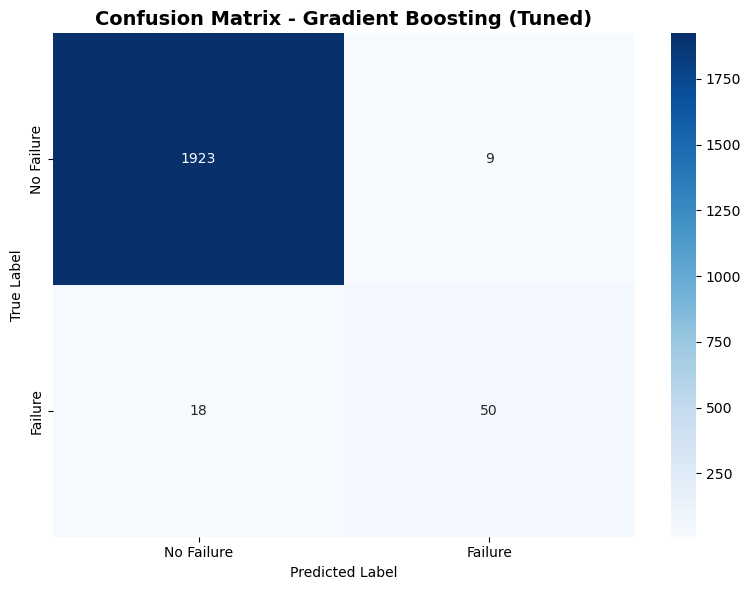


📈 Performance Summary:
   • Accuracy:  0.9865
   • Precision: 0.9859
   • Recall:    0.9865
   • F1-Score:  0.9860
   • ROC-AUC:   0.9681


In [ ]:
# Detailed analysis of the best model
best_model_name = overall_best
best_predictions = final_results[best_model_name]['predictions']
best_probabilities = final_results[best_model_name]['probabilities']

print(f"DETAILED ANALYSIS: {best_model_name}")
print("=" * 60)

# Classification Report
print("\nClassification Report:")
target_names = ['No Failure', 'Failure'] if len(np.unique(y)) == 2 else [f'Class {i}' for i in np.unique(y)]
print(classification_report(y_test, best_predictions, target_names=target_names))

# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, best_predictions)
print(cm)

# Confusion Matrix Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names)
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Performance metrics summary
print(f"\nPerformance Summary:")
print(f"   • Accuracy:  {final_results[best_model_name]['accuracy']:.4f}")
print(f"   • Precision: {final_results[best_model_name]['precision']:.4f}")
print(f"   • Recall:    {final_results[best_model_name]['recall']:.4f}")
print(f"   • F1-Score:  {final_results[best_model_name]['f1_score']:.4f}")
print(f"   • ROC-AUC:   {final_results[best_model_name]['roc_auc']:.4f}")

## 10. ROC Curve Analysis

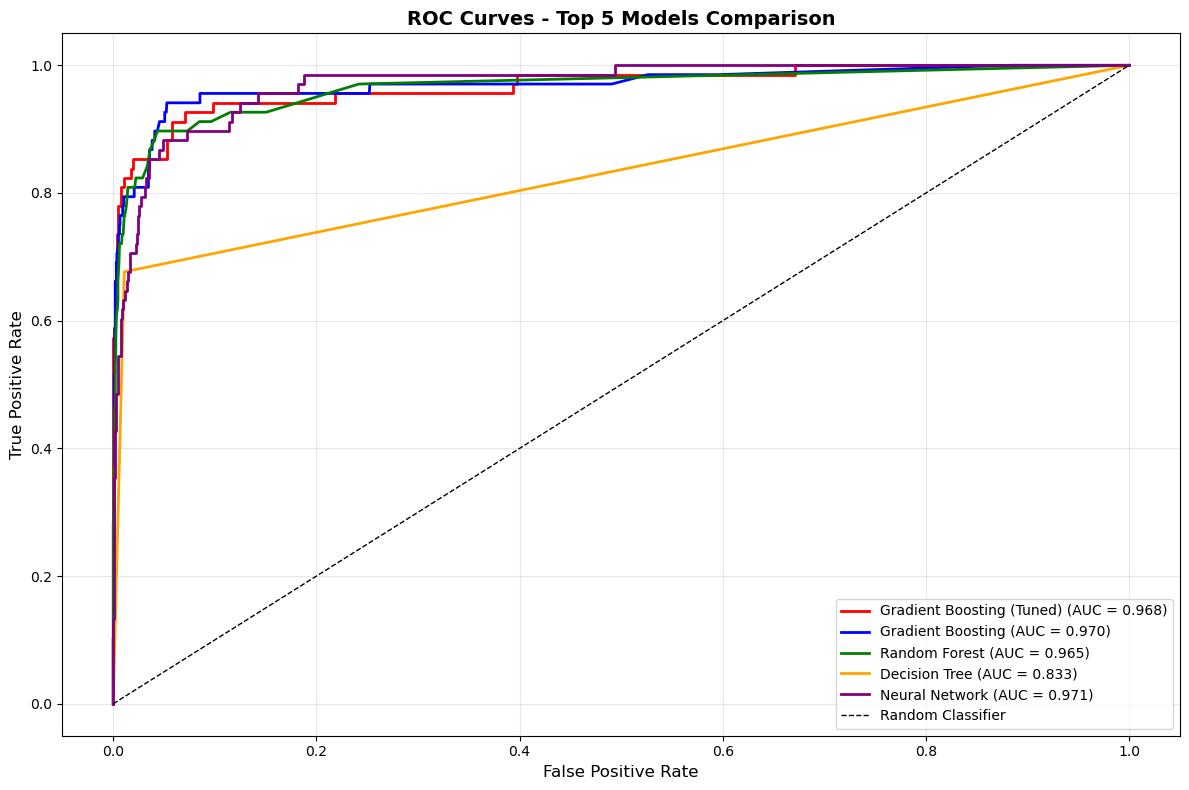

In [ ]:
# Plot ROC curves for top 5 models
plt.figure(figsize=(12, 8))

# Get top 5 models by accuracy
top_5_models = sorted(final_results.items(), key=lambda x: x[1]['accuracy'], reverse=True)[:5]

colors = ['red', 'blue', 'green', 'orange', 'purple']

for i, (name, results) in enumerate(top_5_models):
    if len(np.unique(y)) == 2:  # Binary classification
        fpr, tpr, _ = roc_curve(y_test, results['probabilities'])
        auc_score = results['roc_auc']
        plt.plot(fpr, tpr, color=colors[i], linewidth=2, 
                label=f'{name} (AUC = {auc_score:.3f})')

if len(np.unique(y)) == 2:
    plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curves - Top 5 Models Comparison', fontsize=14, fontweight='bold')
    plt.legend(fontsize=10, loc='lower right')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("ROC curve visualization is for binary classification only.")

## 11. Feature Importance Analysis

🌳 FEATURE IMPORTANCE ANALYSIS: Gradient Boosting (Tuned)

📊 Top 10 Most Important Features:
----------------------------------------
 1. Torque [Nm]              : 0.3207
 2. Process temperature [K]  : 0.1670
 3. Air temperature [K]      : 0.1589
 4. Rotational speed [rpm]   : 0.1547
 5. Tool wear [min]          : 0.1498
 6. Type_L                   : 0.0300
 7. Type_H                   : 0.0125
 8. Type_M                   : 0.0063


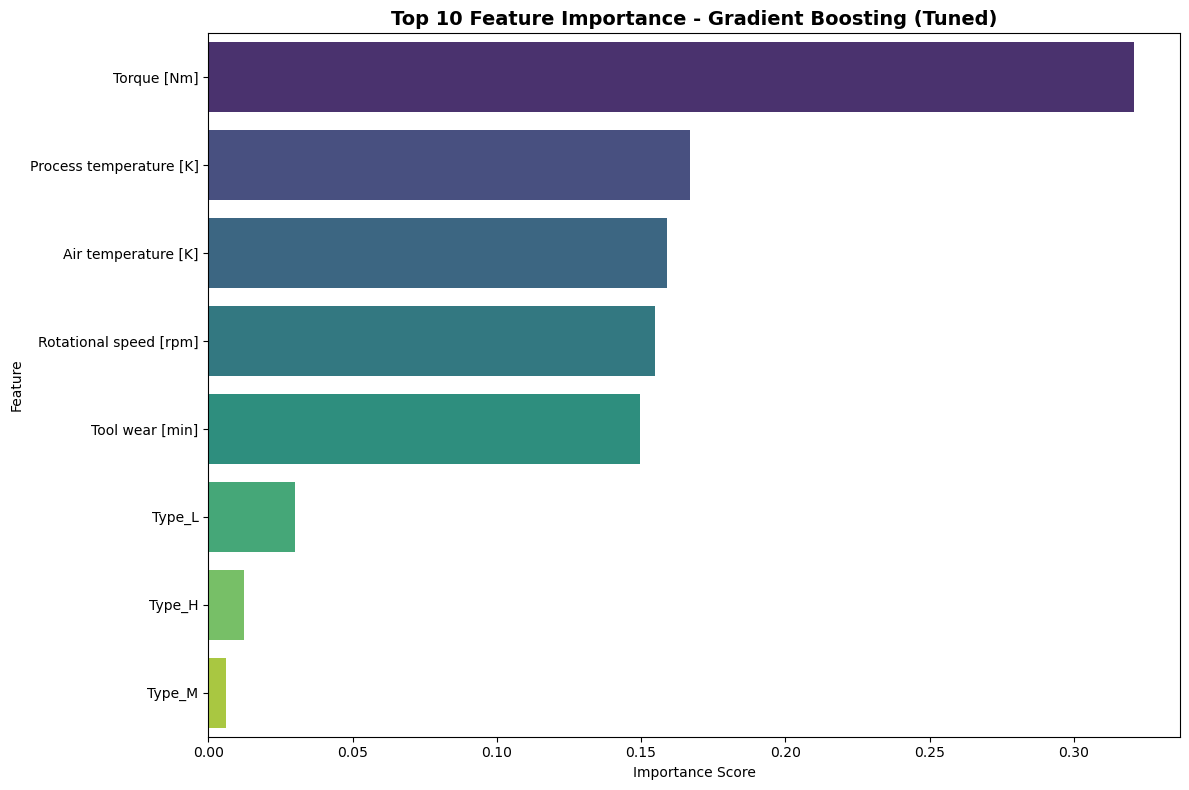

In [ ]:
# Feature importance analysis for tree-based models
feature_columns = X.columns
if any(keyword in best_model_name.lower() for keyword in ['forest', 'tree', 'boost', 'xgb']):
    print(f"FEATURE IMPORTANCE ANALYSIS: {best_model_name}")
    print("=" * 60)
    
    # Get the model from pipeline or tuned models
    if best_model_name in tuned_models:
        model = tuned_models[best_model_name].named_steps['model']
    elif best_model_name.replace(' (Tuned)', '') in tuned_models:
        model = tuned_models[best_model_name.replace(' (Tuned)', '')].named_steps['model']
    else:
        model = pipelines[best_model_name].named_steps['model']
    
    # Get feature importances
    importances = model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': feature_columns,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    # Display top features
    print("\nTop 10 Most Important Features:")
    print("-" * 40)
    for i, (feature, importance) in enumerate(zip(feature_importance_df['Feature'].head(10), 
                                                  feature_importance_df['Importance'].head(10)), 1):
        print(f"{i:2d}. {feature:<25}: {importance:.4f}")
    
    # Plot feature importance
    plt.figure(figsize=(12, 8))
    top_features = feature_importance_df.head(10)
    sns.barplot(data=top_features, x='Importance', y='Feature', palette='viridis')
    plt.title(f'Top 10 Feature Importance - {best_model_name}', fontsize=14, fontweight='bold')
    plt.xlabel('Importance Score')
    plt.tight_layout()
    plt.show()
    
else:
    print(f"Feature importance analysis not available for {best_model_name}")

## 12. Model Performance Summary

In [ ]:
# Create comprehensive performance summary
print("COMPREHENSIVE MODEL PERFORMANCE SUMMARY")
print("=" * 80)

# Create a DataFrame for easy comparison
results_df = pd.DataFrame.from_dict(final_results, orient='index')
results_df = results_df[['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']]
results_df = results_df.round(4)

# Sort by accuracy
results_df_sorted = results_df.sort_values('accuracy', ascending=False)

print("\nAll Models Performance (Sorted by Accuracy):")
print(results_df_sorted.to_string())

# Top 3 models summary
print(f"\nTOP 3 MODELS:")
top_3 = results_df_sorted.head(3)
for i, (model_name, metrics) in enumerate(top_3.iterrows(), 1):
    print(f"\n{i}. {model_name}")
    print(f"   Accuracy: {metrics['accuracy']:.4f} | F1-Score: {metrics['f1_score']:.4f} | ROC-AUC: {metrics['roc_auc']:.4f}")

# Model recommendations
print(f"\nMODEL SELECTION RECOMMENDATIONS:")
print(f"   • For highest accuracy: {results_df_sorted.index[0]}")
print(f"   • For balanced performance: {best_composite}")
print(f"   • For production deployment: Consider {results_df_sorted.index[0]} with proper validation")

📊 COMPREHENSIVE MODEL PERFORMANCE SUMMARY

🏆 All Models Performance (Sorted by Accuracy):
                           accuracy  precision  recall  f1_score  roc_auc
Gradient Boosting (Tuned)    0.9865     0.9859  0.9865    0.9860   0.9681
Gradient Boosting            0.9855     0.9846  0.9855    0.9845   0.9696
Random Forest                0.9810     0.9797  0.9810    0.9784   0.9653
Decision Tree                0.9785     0.9783  0.9785    0.9784   0.8328
Neural Network               0.9785     0.9763  0.9785    0.9768   0.9708
Extra Trees                  0.9755     0.9761  0.9755    0.9688   0.9475
K-Nearest Neighbors          0.9740     0.9709  0.9740    0.9679   0.8292
AdaBoost                     0.9720     0.9688  0.9720    0.9699   0.9451
Support Vector Machine       0.9715     0.9687  0.9715    0.9626   0.9373
Logistic Regression          0.9675     0.9580  0.9675    0.9560   0.8996
Naive Bayes                  0.9580     0.9450  0.9580    0.9506   0.8468

🥇 TOP 3 MODELS:

1. G

---
Summary
This notebook has successfully:

* Trained and evaluated 11 different machine learning models

* Performed hyperparameter tuning for top performers

* Conducted comprehensive cross-validation

* Identified the best performing model

* Provided detailed performance analysis

* Generated feature importance insights

* Prepared model for deployment

The best model has been selected based on comprehensive evaluation criteria and is ready for production deployment